In [1]:
import subprocess
import os
import glob

# --- 설정 ---
input_folder = "./sample_data"
output_folder = "./svg_output"
# --- ---

os.makedirs(output_folder, exist_ok=True)

search_path = os.path.join(input_folder, '*.ai')
ai_files = glob.glob(search_path)

if not ai_files:
    print(f"'{input_folder}'에서 AI 파일을 찾을 수 없습니다.")
else:
    print(f"총 {len(ai_files)}개의 파일을 변환합니다...")

    for ai_path in ai_files:
        file_name_without_ext = os.path.splitext(os.path.basename(ai_path))[0]
        svg_path = os.path.join(output_folder, f"{file_name_without_ext}.svg")
        
        # 최신 Inkscape (1.0 이상) 버전에 맞는 명령어
        # 입력 파일을 맨 마지막에 두는 것이 최신 방식입니다.
        command = [
            "inkscape",
            ai_path,  # 입력 파일을 먼저 지정
            f"--export-filename={svg_path}"
        ]
        
        print(f"-> 변환 중: {os.path.basename(ai_path)}")
        
        try:
            result = subprocess.run(command, check=True, capture_output=True, text=True)
            print(f"   ✅ 성공: {svg_path}")
        except subprocess.CalledProcessError as e:
            print(f"   ❌ 실패: {os.path.basename(ai_path)}")
            print(f"       Error: {e.stderr.strip()}")

    print("\n모든 작업이 완료되었습니다.")

총 2개의 파일을 변환합니다...
-> 변환 중: 250718_01.ai
   ✅ 성공: ./svg_output/250718_01.svg
-> 변환 중: 250731_[서울버스] 테스트 시안.ai
   ✅ 성공: ./svg_output/250731_[서울버스] 테스트 시안.svg

모든 작업이 완료되었습니다.


In [5]:
from IPython.display import display, SVG, HTML, Image

# 변환된 SVG 파일 경로
svg_file_path = "./svg_output/250731_[서울버스] 테스트 시안.svg"

# 방법 1: SVG 객체로 직접 표시 (가장 권장)
# SVG의 모든 속성을 유지하며 가장 정확하게 표시합니다.
# print("--- 1. display.SVG() 사용 ---")
# display(SVG(filename=svg_file_path))


# 방법 2: HTML <img> 태그로 표시
# 크기 조절 등 HTML/CSS 속성을 함께 적용하고 싶을 때 유용합니다.
print("\n--- 2. display.HTML() 사용 (크기 조절 예시) ---")
display(HTML(f'<img src="{svg_file_path}" width="900px">'))



--- 2. display.HTML() 사용 (크기 조절 예시) ---


✅ 총 5개의 레이어(<g> 태그)를 감지했습니다.


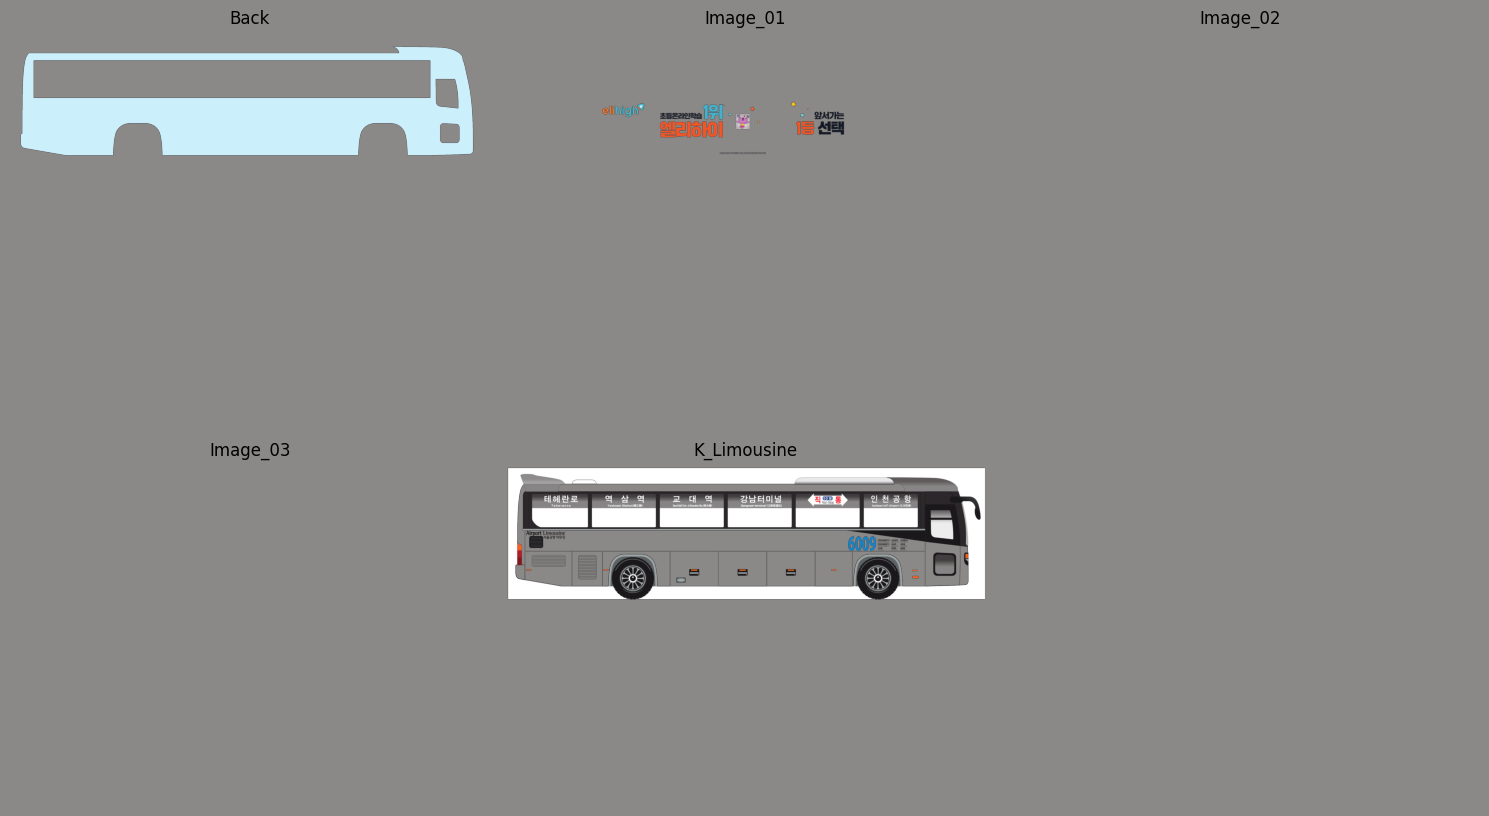

In [13]:
import xml.etree.ElementTree as ET
import cairosvg
import matplotlib.pyplot as plt
import io
import math

# --- 1. 파일 경로 및 네임스페이스 정의 (수정) ---
svg_file_path = "./svg_output/250731_[서울버스] 테스트 시안.svg"
# SVG 관련 네임스페이스를 미리 정의해 둡니다.
ns = {
    'svg': 'http://www.w3.org/2000/svg',
    'inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

# --- 2. SVG 파일 파싱 및 레이어(최상위 <g> 태그) 추출 ---
try:
    tree = ET.parse(svg_file_path)
    root = tree.getroot()

    defs = root.find('svg:defs', ns)
    top_level_groups = root.findall('svg:g', ns)
    
    print(f"✅ 총 {len(top_level_groups)}개의 레이어(<g> 태그)를 감지했습니다.")

    # --- 3. 각 레이어를 개별 SVG로 만들고 시각화 ---
    if top_level_groups:
        num_layers = len(top_level_groups)
        cols = 3
        rows = math.ceil(num_layers / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
        axes = axes.flatten()
        fig.patch.set_facecolor("#8b8888")

        for i, g_element in enumerate(top_level_groups):
            # 새로운 SVG 루트 생성 및 속성 복사
            new_root = ET.Element('svg', attrib=root.attrib)
            
            if defs is not None:
                new_root.append(defs)
            
            new_root.append(g_element)
            
            # SVG를 문자열과 이미지 바이트로 변환
            svg_string = ET.tostring(new_root, encoding='unicode')
            png_bytes = cairosvg.svg2png(bytestring=svg_string.encode('utf-8'))
            img = plt.imread(io.BytesIO(png_bytes))
            
            # 서브플롯에 이미지 표시
            ax = axes[i]
            ax.imshow(img)
            
            # --- 레이어 이름 추출 로직 (수정된 부분) ---
            # 우선순위 1: inkscape:label 속성 확인
            layer_name = g_element.get(f'{{{ns["inkscape"]}}}label')
            
            # 우선순위 2: id 속성 확인 (inkscape:label이 없을 경우)
            if not layer_name:
                layer_name = g_element.get('id')

            # 우선순위 3: 기본값 (둘 다 없을 경우)
            if not layer_name:
                layer_name = f'Layer {i+1} (No Name)'
            # --- 로직 끝 ---

            ax.set_title(layer_name) # 추출한 이름으로 타이틀 설정
            ax.axis('off')

        # 남는 서브플롯 숨기기
        for j in range(num_layers, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"❌ 오류: '{svg_file_path}' 파일을 찾을 수 없습니다.")
except ET.ParseError:
    print(f"❌ 오류: 파일을 SVG(XML) 형식으로 파싱할 수 없습니다.")
except Exception as e:
    print(f"❌ 오류 발생: {e}")

In [14]:
# 필요한 라이브러리를 추가합니다.
import numpy as np

# ... (이전 코드는 동일) ...

for i, g_element in enumerate(top_level_groups):
    # 새로운 SVG 루트를 생성하고 원본의 속성(viewBox 등)을 복사합니다.
    new_root = ET.Element('svg', attrib=root.attrib)
    
    # 원본의 <defs>가 있다면 추가합니다.
    if defs is not None:
        new_root.append(defs)
    
    # 현재 순회의 <g> 태그(레이어)를 추가합니다.
    new_root.append(g_element)
    
    # 새로운 SVG XML 트리를 문자열로 변환합니다.
    svg_string = ET.tostring(new_root, encoding='unicode')
    
    # SVG 문자열을 PNG 이미지 바이트로 변환합니다.
    png_bytes = cairosvg.svg2png(bytestring=svg_string.encode('utf-8'))
    
    # PNG 바이트를 Matplotlib에서 읽을 수 있는 이미지(Numpy 배열)로 변환합니다.
    img = plt.imread(io.BytesIO(png_bytes))
    
    # --- [추가된 부분] 레이어 2 (i=1)의 픽셀 카운트 ---
    if i == 1:
        # img 배열의 모양(세로, 가로, 채널)에서 4번째 채널(알파)을 선택합니다.
        alpha_channel = img[:, :, 3] 
        
        # 알파 채널 값이 0보다 큰 픽셀(투명하지 않은 픽셀)을 찾습니다.
        non_transparent_pixels = np.sum(alpha_channel > 0)
        
        print(f"🎨 레이어 2의 투명하지 않은 픽셀 수: {non_transparent_pixels}개")
    # --- [여기까지 추가] ---
    
    # 서브플롯에 이미지를 표시합니다.
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f'Layer {i+1}')
    ax.axis('off') # 축 숨기기

🎨 레이어 2의 투명하지 않은 픽셀 수: 57648개


✅ 총 5개의 레이어(<g> 태그)를 감지했습니다.


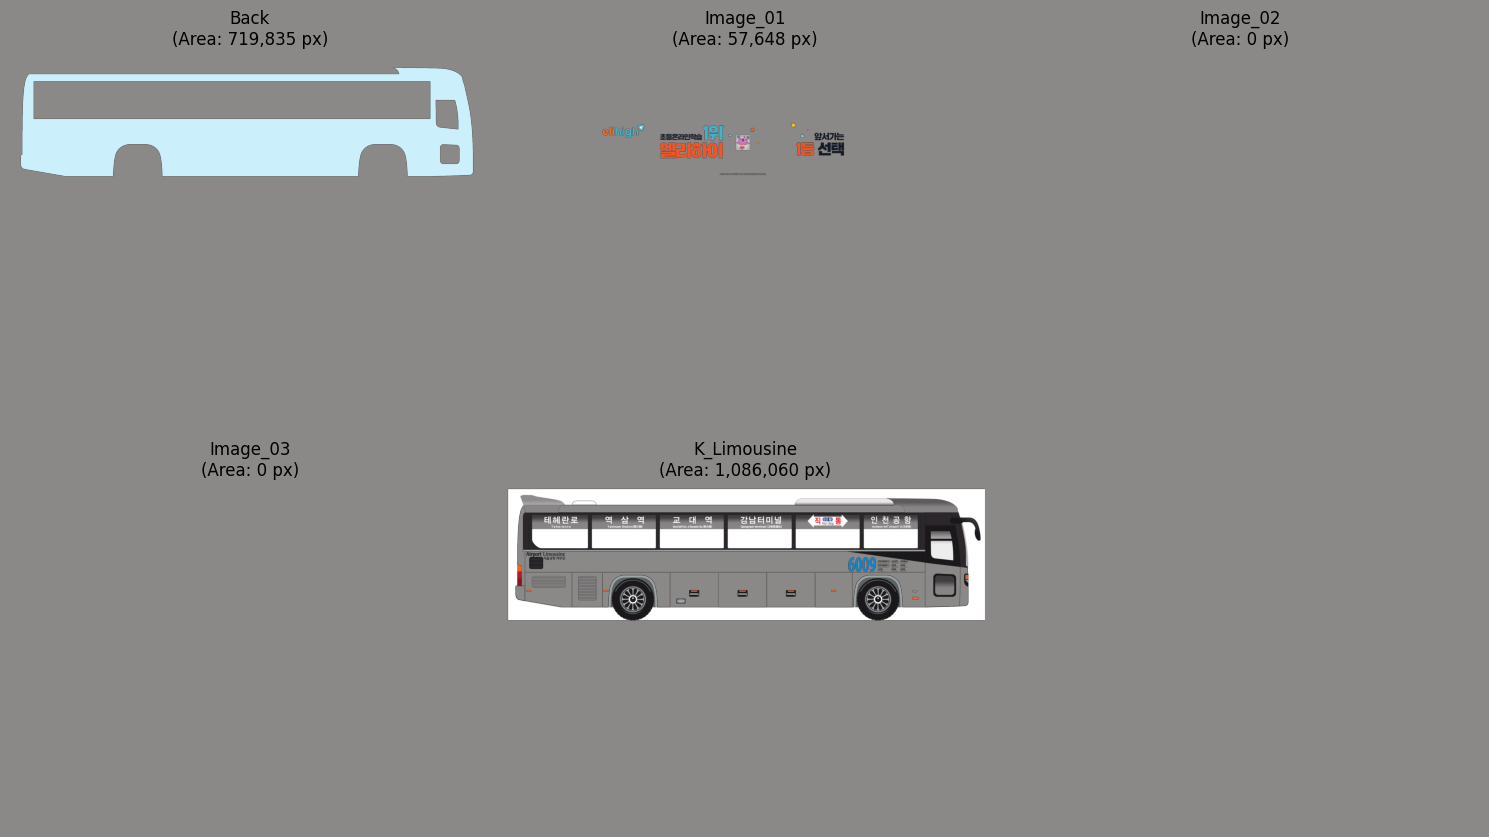

In [15]:
import xml.etree.ElementTree as ET
import cairosvg
import matplotlib.pyplot as plt
import io
import math
import numpy as np # 픽셀 계산을 위해 numpy를 추가합니다.

# --- 1. 파일 경로 및 네임스페이스 정의 ---
svg_file_path = "./svg_output/250731_[서울버스] 테스트 시안.svg"
ns = {
    'svg': 'http://www.w3.org/2000/svg',
    'inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

# --- 2. SVG 파일 파싱 및 레이어 추출 ---
try:
    tree = ET.parse(svg_file_path)
    root = tree.getroot()
    defs = root.find('svg:defs', ns)
    top_level_groups = root.findall('svg:g', ns)
    
    print(f"✅ 총 {len(top_level_groups)}개의 레이어(<g> 태그)를 감지했습니다.")

    # --- 3. 각 레이어를 시각화하고 픽셀 면적 계산 ---
    if top_level_groups:
        num_layers = len(top_level_groups)
        cols = 3
        rows = math.ceil(num_layers / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
        axes = axes.flatten()
        fig.patch.set_facecolor("#8b8888")

        for i, g_element in enumerate(top_level_groups):
            # 개별 레이어로 새 SVG 생성
            new_root = ET.Element('svg', attrib=root.attrib)
            if defs is not None:
                new_root.append(defs)
            new_root.append(g_element)
            
            # SVG를 PNG 이미지로 변환
            svg_string = ET.tostring(new_root, encoding='unicode')
            png_bytes = cairosvg.svg2png(bytestring=svg_string.encode('utf-8'))
            
            # PNG를 Numpy 배열로 변환 (RGBA 형태)
            img = plt.imread(io.BytesIO(png_bytes))
            
            ax = axes[i]
            ax.imshow(img)

            # --- 픽셀 면적 계산 및 타이틀 적용 (수정된 부분) ---
            
            # 1. 픽셀 면적 계산
            # 알파 채널(투명도)이 0보다 큰 픽셀, 즉 투명하지 않은 픽셀의 수를 계산합니다.
            alpha_channel = img[:, :, 3]
            pixel_area = np.sum(alpha_channel > 0)
            
            # 2. 레이어 이름 추출 (이전과 동일한 안정적인 로직)
            layer_name = g_element.get(f'{{{ns["inkscape"]}}}label')
            if not layer_name:
                layer_name = g_element.get('id')
            if not layer_name:
                layer_name = f'Layer {i+1} (No Name)'
            
            # 3. 타이틀에 레이어 이름과 픽셀 면적 함께 표시
            # f-string의 ':, ' 포맷은 숫자에 1,000 단위 콤마를 찍어줍니다.
            title_text = f"{layer_name}\n(Area: {pixel_area:,} px)"
            ax.set_title(title_text)
            
            # --- 로직 끝 ---

            ax.axis('off')

        # 남는 서브플롯 숨기기
        for j in range(num_layers, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"❌ 오류: '{svg_file_path}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"❌ 오류 발생: {e}")